In [2]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy.signal import resample
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "3"  # 使用第四块GPU（从0开始）

这里我们读入三个csv文件，分别是训练集(train：7292个数据)、线上测试集(test:7500个数据)和提交样例(sub)。把训练集读入进来之后就可以把标签(y)先分离出来了

type(y):fragment_id
0        0
1        0
2        0
3        0
4        0
        ..
7277    18
7288    18
7289    18
7290    18
7291    18
Name: behavior_id, Length: 7292, dtype: int64

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sub = pd.read_csv('submit.csv')
y = train.groupby('fragment_id')['behavior_id'].min()

In [3]:
train['mod'] = (train.acc_x ** 2 + train.acc_y ** 2 + train.acc_z ** 2) ** .5
train['modg'] = (train.acc_xg ** 2 + train.acc_yg ** 2 + train.acc_zg ** 2) ** .5
test['mod'] = (test.acc_x ** 2 + test.acc_y ** 2 + test.acc_z ** 2) ** .5
test['modg'] = (test.acc_xg ** 2 + test.acc_yg ** 2 + test.acc_zg ** 2) ** .5

In [4]:
x = np.zeros((7292, 8, 60, 1))
t = np.zeros((7500, 8, 60, 1))
# 重采样成相同长度（60）
for i in tqdm(range(7292)):
    tmp = train[train.fragment_id == i][:60]
    x[i,:,:, 0] = resample(tmp.drop(['fragment_id', 'time_point', 'behavior_id'],
                                    axis=1), 60, np.array(tmp.time_point))[0].transpose(1,0)
for i in tqdm(range(7500)):
    tmp = test[test.fragment_id == i][:60]
    t[i,:,:, 0] = resample(tmp.drop(['fragment_id', 'time_point'],
                                    axis=1), 60, np.array(tmp.time_point))[0].transpose(1,0)
    

100%|██████████| 7500/7500 [00:11<00:00, 635.90it/s]


In [5]:
# 分割数据
x_ = np.zeros((21876, 8, 30, 1))
t_ = np.zeros((22500, 8, 30, 1))
y_l = np.zeros((21876,))
for i in tqdm(range(7292)):
    x_[i,:,:,:] = x[i,:,0:30,:]
    x_[i+7292,:,:,:] = x[i,:,15:45,:]
    x_[i+14584,:,:,:] = x[i,:,30:60,:]
    y_l[i] = np.array(y)[i]
    y_l[i+7292] = np.array(y)[i]
    y_l[i+14584] = np.array(y)[i]
    
for i in tqdm(range(7500)):
    t_[i,:,:,:] = t[i,:,0:30,:]
    t_[i+7500,:,:,:] = t[i,:,15:45,:]
    t_[i+15000,:,:,:] = t[i,:,30:60,:]

100%|██████████| 7500/7500 [00:00<00:00, 124978.27it/s]


In [4]:
if __name__ == '__main__'"
    from keras.models import load_model
    import numpy as np
    import pandas as pd
    from tqdm import tqdm
    from scipy.signal import resample
    from tensorflow.keras.layers import *
    from tensorflow.keras.models import Model
    from tensorflow.keras.optimizers import Adam
    from tensorflow.keras.utils import to_categorical
    from sklearn.model_selection import StratifiedKFold
    from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
    import os
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
    os.environ["CUDA_VISIBLE_DEVICES"] = "3"  # 使用第四块GPU（从0开始）
    pre = np.zeros((22500, 19))
    for model in tqdm(['fold0.h5','fold1.h5','fold2.h5','fold3.h5','fold4.h5']):
        print('------------模型开始预测--------------')
        model = load_model(model)

        pre += model.predict(t_, verbose=0, batch_size=1024) / 5.



    for i in range(7500):
        pre[i] += pre[i + 7500]
        pre[i] += pre[i + 7500 * 2]

    pre_ave = pre[:7500] / 3. 

    print('------------开始提取重新训练数据--------------')
    retrain_index = []
    retest_index = []
    retrain_label = []
    for i in tqdm(range(len(pre_ave))):
        sort_ = sorted(pre_ave[i])
        list_ = pre_ave[i].tolist()
        #print(list_)
        if sort_[-1] > 0.8 and sort_[-1] - sort_[-2] > 0.6:
            retrain_index.append(i)
            retrain_label.append(list_.index(max(list_)))
        else:
            retest_index.append(i)


    print('------------开始合并训练数据--------------')
    train = pd.read_csv('train.csv')
    test = pd.read_csv('test.csv')
    sub = pd.read_csv('sub.csv')
    y = train.groupby('fragment_id')['behavior_id'].min()

    train['mod'] = (train.acc_x ** 2 + train.acc_y ** 2 + train.acc_z ** 2) ** .5
    train['modg'] = (train.acc_xg ** 2 + train.acc_yg ** 2 + train.acc_zg ** 2) ** .5
    test['mod'] = (test.acc_x ** 2 + test.acc_y ** 2 + test.acc_z ** 2) ** .5
    test['modg'] = (test.acc_xg ** 2 + test.acc_yg ** 2 + test.acc_zg ** 2) ** .5

    x = np.zeros((7292, 8, 60, 1))
    t = np.zeros((7500, 8, 60, 1))
    # 重采样成相同长度（60）
    for i in tqdm(range(7292)):
        tmp = train[train.fragment_id == i][:60]
        x[i,:,:, 0] = resample(tmp.drop(['fragment_id', 'time_point', 'behavior_id'],
                                        axis=1), 60, np.array(tmp.time_point))[0].transpose(1,0)
    for i in tqdm(range(7500)):
        tmp = test[test.fragment_id == i][:60]
        t[i,:,:, 0] = resample(tmp.drop(['fragment_id', 'time_point'],
                                        axis=1), 60, np.array(tmp.time_point))[0].transpose(1,0)


    x_new = list(x)
    y_new = list(y.values)
    x_test_new = []

    # 组合新的训练集和标签
    for i, j in zip(retrain_index, retrain_label):
        x_new.append(t[i])
        y_new.append(j)


    # 提取出新的测试集
    for i in retest_index:
        x_test_new.append(t[i])

    x_new = np.array(x_new)
    y_new = np.array(y_new)
    x_test_new = np.array(x_test_new)

    print('------------开始分割训练数据--------------')
    # 分割数据
    x_ = np.zeros((len(x_new)*3, 8, 30, 1))
    t_ = np.zeros((len(x_test_new)*3, 8, 30, 1))
    y_l = np.zeros((len(y_new)*3,))
    for i in tqdm(range(7292)):
        x_[i,:,:,:] = x_new[i,:,0:30,:]
        x_[i+len(x_new),:,:,:] = x_new[i,:,15:45,:]
        x_[i+len(x_new)*2,:,:,:] = x_new[i,:,30:60,:]
        y_l[i] = np.array(y_new)[i]
        y_l[i+len(y_new)] = np.array(y_new)[i]
        y_l[i+len(y_new)*2] = np.array(y_new)[i]

    for i in tqdm(range(len(x_test_new))):
        t_[i,:,:,:] = x_test_new[i,:,0:30,:]
        t_[i+len(x_test_new),:,:,:] = x_test_new[i,:,15:45,:]
        t_[i+len(x_test_new)*2,:,:,:] = x_test_new[i,:,30:60,:]


    def Net():
        input = Input(shape=(8, 30, 1))
        X = Conv2D(filters=64,
                   kernel_size=(5, 5),
                   activation='relu',
                   padding='same')(input)
        X = Conv2D(filters=128,
                   kernel_size=(5, 5),
                   activation='relu',
                   padding='same')(X)
        X = MaxPooling2D()(X)
        X = Dropout(0.2)(X)
        X = Conv2D(filters=256,
                   kernel_size=(5, 5),
                   activation='relu',
                   padding='same')(X)
        X = Dropout(0.3)(X)
        X = Conv2D(filters=512,
                   kernel_size=(5, 5),
                   activation='relu',
                   padding='same')(X)
        X = GlobalMaxPooling2D()(X)
        X = Dropout(0.5)(X)
        X = Dense(19, activation='softmax')(X)
        return Model([input], X)

    kfold = StratifiedKFold(5, shuffle=True)

    print('------------开始训练网络--------------')
    # 设置测试集的准确度 acc是指模型训练精度，val_acc是指模型在验证集上的精度
    proba_t = np.zeros((len(x_test_new)*3, 19))
    # 从所有train集中均分出来一个作为验证集
    for fold, (xx, yy) in enumerate(kfold.split(x_, y_l)):
        print('第',fold, '次')
        # 将二元组转为矩阵表示
        y_ = to_categorical(y_l, num_classes=19)
        model = Net()
        # 设置训练参数：loss使用'分类交叉熵函数'，优化器使用Adam， 列表（metrics）使用accuracy：表示为到上一个batch为止的准确度
        model.compile(loss='categorical_crossentropy',
                      optimizer=Adam(),
                      metrics=['acc'])
        # 回调监控函数（修改学习率）：
        # monitor：要监测的数量。
        # factor：学习速率降低的因素。new_lr = lr * factor
        # patience：没有提升的epoch数，之后学习率将降低。
        # verbose：日志显示：0：安静，1：更新消息。为1表示输出epoch模型保存信息，默认为0表示不输出该信息
        # mode：{auto，min，max}之一。在min模式下，当监测量停止下降时，lr将减少；在max模式下，当监测数量停止增加时，它将减少；在auto模式下，从监测数量的名称自动推断方向。
        plateau = ReduceLROnPlateau(monitor="val_acc",
                                    verbose=0,
                                    mode='max',
                                    factor=0.1,
                                    patience=10)
        # 回调停止函数（及时停止防止过拟合）：
        # 参数属性和上述一致
        early_stopping = EarlyStopping(monitor='val_acc',
                                       verbose=0,
                                       mode='max',
                                       patience=15)
        # 保存模型设置
        # save_best_only：当设置为True时，将只保存在验证集上性能最好的模型
        checkpoint = ModelCheckpoint(f'new_fold{fold}.h5',
                                     monitor='val_acc',
                                     verbose=0,
                                     mode='max',
                                     save_best_only=True)
        # 开始训练
        # validation_data：形式为（X，y）的tuple，是指定的验证集。此参数将覆盖validation_spilt。
        # shuffle：表示是否在训练过程中随机打乱输入样本的顺序。
        model.fit(x_[xx], y_[xx],
                  epochs=100,
                  batch_size=512,
                  verbose=1,
                  shuffle=True,
                  validation_data=(x_[yy], y_[yy]),
                  callbacks=[plateau, early_stopping, checkpoint])
        # 保存5个交叉验证集模型的参数
        model.load_weights(f'new_fold{fold}.h5')
        # 预测输出为softmax值，对五次训练结果取平均
        proba_t += model.predict(t_, verbose=0, batch_size=1024) / 5.
        
    print('------------开始合并结果--------------')
    for i in tqdm(range(len(retest_indexretest_index))):
        proba_t[i] += proba_t[i + len(retest_index)]
        proba_t[i] += proba_t[i + len(retest_index) * 2]

    pre_new_sub = proba_t[:len(retest_index)]
    sub_new = np.argmax(pre_new_sub, axis=1)

    for i,j in tqdm(zip(range(len(retest_index)),range(len(retrain_index)))):
        sub.iloc[retest_index[i],1] = sub_new[i]
        sub.iloc[retrain_index[j],1] = retrain_label[j]

    sub.to_csv('submit_new.csv',index=False)

------------模型开始训练--------------


OSError: Unable to open file (unable to open file: name = 'fold0.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [102]:
pre_ave = pre[:7500] / 3. 

In [239]:
retrain_index = []
retest_index = []
retrain_label = []
for i in range(len(pre_ave)):
    sort_ = sorted(pre_ave[i])
    list_ = pre_ave[i].tolist()
    #print(list_)
    if sort_[-1] > 0.8 and sort_[-1] - sort_[-2] > 0.6:
        retrain_index.append(i)
        retrain_label.append(list_.index(max(list_)))
    else:
        retest_index.append(i)
    

In [240]:
len(retrain_index)

2672

In [234]:
len(retrain_index) + len(retest_index)

7500

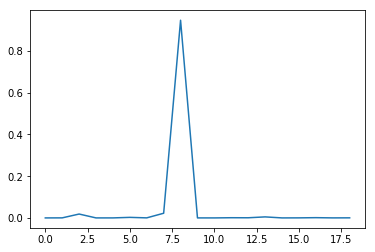

In [235]:
import matplotlib.pyplot as plt
plt.plot(pre_ave[10])

In [153]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sub = pd.read_csv('submit.csv')
y = train.groupby('fragment_id')['behavior_id'].min()

In [154]:
train['mod'] = (train.acc_x ** 2 + train.acc_y ** 2 + train.acc_z ** 2) ** .5
train['modg'] = (train.acc_xg ** 2 + train.acc_yg ** 2 + train.acc_zg ** 2) ** .5
test['mod'] = (test.acc_x ** 2 + test.acc_y ** 2 + test.acc_z ** 2) ** .5
test['modg'] = (test.acc_xg ** 2 + test.acc_yg ** 2 + test.acc_zg ** 2) ** .5

In [155]:
x = np.zeros((7292, 8, 60, 1))
t = np.zeros((7500, 8, 60, 1))
# 重采样成相同长度（60）
for i in tqdm(range(7292)):
    tmp = train[train.fragment_id == i][:60]
    x[i,:,:, 0] = resample(tmp.drop(['fragment_id', 'time_point', 'behavior_id'],
                                    axis=1), 60, np.array(tmp.time_point))[0].transpose(1,0)
for i in tqdm(range(7500)):
    tmp = test[test.fragment_id == i][:60]
    t[i,:,:, 0] = resample(tmp.drop(['fragment_id', 'time_point'],
                                    axis=1), 60, np.array(tmp.time_point))[0].transpose(1,0)

100%|██████████| 7500/7500 [00:12<00:00, 615.14it/s]


In [163]:
x_new = list(x)
y_new = list(y.values)
x_test_new = []

# 组合新的训练集和标签
for i, j in zip(retrain_index, retrain_label):
    x_new.append(t[i])
    y_new.append(j)


# 提取出新的测试集
for i in retest_index:
    x_test_new.append(t[i])
    
x_new = np.array(x_new)
y_new = np.array(y_new)
x_test_new = np.array(x_test_new)

In [162]:
x_new.shape

(10427, 8, 60, 1)

In [164]:
x_test_new.shape

(4365, 8, 60, 1)

In [169]:
# 分割数据
x_ = np.zeros((len(x_new)*3, 8, 30, 1))
t_ = np.zeros((len(x_test_new)*3, 8, 30, 1))
y_l = np.zeros((len(y_new)*3,))
for i in tqdm(range(7292)):
    x_[i,:,:,:] = x_new[i,:,0:30,:]
    x_[i+len(x_new),:,:,:] = x_new[i,:,15:45,:]
    x_[i+len(x_new)*2,:,:,:] = x_new[i,:,30:60,:]
    y_l[i] = np.array(y_new)[i]
    y_l[i+len(y_new)] = np.array(y_new)[i]
    y_l[i+len(y_new)*2] = np.array(y_new)[i]
    
for i in tqdm(range(len(x_test_new))):
    t_[i,:,:,:] = x_test_new[i,:,0:30,:]
    t_[i+len(x_test_new),:,:,:] = x_test_new[i,:,15:45,:]
    t_[i+len(x_test_new)*2,:,:,:] = x_test_new[i,:,30:60,:]

100%|██████████| 4365/4365 [00:00<00:00, 144564.93it/s]


In [170]:
def Net():
    input = Input(shape=(8, 30, 1))
    X = Conv2D(filters=64,
               kernel_size=(5, 5),
               activation='relu',
               padding='same')(input)
    X = Conv2D(filters=128,
               kernel_size=(5, 5),
               activation='relu',
               padding='same')(X)
    X = MaxPooling2D()(X)
    X = Dropout(0.2)(X)
    X = Conv2D(filters=256,
               kernel_size=(5, 5),
               activation='relu',
               padding='same')(X)
    X = Dropout(0.3)(X)
    X = Conv2D(filters=512,
               kernel_size=(5, 5),
               activation='relu',
               padding='same')(X)
    X = GlobalMaxPooling2D()(X)
    X = Dropout(0.5)(X)
    X = Dense(19, activation='softmax')(X)
    return Model([input], X)

In [171]:
kfold = StratifiedKFold(5, shuffle=True)

In [174]:
# 设置测试集的准确度 acc是指模型训练精度，val_acc是指模型在验证集上的精度
proba_t = np.zeros((22500, 19))
# 从所有train集中均分出来一个作为验证集
for fold, (xx, yy) in enumerate(kfold.split(x_, y_l)):
    print('第',fold, '次')
    # 将二元组转为矩阵表示
    y_ = to_categorical(y_l, num_classes=19)
    model = Net()
    # 设置训练参数：loss使用'分类交叉熵函数'，优化器使用Adam， 列表（metrics）使用accuracy：表示为到上一个batch为止的准确度
    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(),
                  metrics=['acc'])
    # 回调监控函数（修改学习率）：
    # monitor：要监测的数量。
    # factor：学习速率降低的因素。new_lr = lr * factor
    # patience：没有提升的epoch数，之后学习率将降低。
    # verbose：日志显示：0：安静，1：更新消息。为1表示输出epoch模型保存信息，默认为0表示不输出该信息
    # mode：{auto，min，max}之一。在min模式下，当监测量停止下降时，lr将减少；在max模式下，当监测数量停止增加时，它将减少；在auto模式下，从监测数量的名称自动推断方向。
    plateau = ReduceLROnPlateau(monitor="val_acc",
                                verbose=0,
                                mode='max',
                                factor=0.1,
                                patience=10)
    # 回调停止函数（及时停止防止过拟合）：
    # 参数属性和上述一致
    early_stopping = EarlyStopping(monitor='val_acc',
                                   verbose=0,
                                   mode='max',
                                   patience=15)
    # 保存模型设置
    # save_best_only：当设置为True时，将只保存在验证集上性能最好的模型
    checkpoint = ModelCheckpoint(f'new_fold{fold}.h5',
                                 monitor='val_acc',
                                 verbose=0,
                                 mode='max',
                                 save_best_only=True)
    # 开始训练
    # validation_data：形式为（X，y）的tuple，是指定的验证集。此参数将覆盖validation_spilt。
    # shuffle：表示是否在训练过程中随机打乱输入样本的顺序。
    model.fit(x_[xx], y_[xx],
              epochs=100,
              batch_size=32,
              verbose=1,
              shuffle=True,
              validation_data=(x_[yy], y_[yy]),
              callbacks=[plateau, early_stopping, checkpoint])
    # 保存5个交叉验证集模型的参数
    model.load_weights(f'new_fold{fold}.h5')
    # 预测输出为softmax值，对五次训练结果取平均
    proba_t += model.predict(t_, verbose=0, batch_size=1024) / 5.

第 0 次
Train on 25017 samples, validate on 6264 samples
Epoch 1/100
25017/25017 [==============================] - 140s 6ms/step - loss: 1.4065 - acc: 0.5420 - val_loss: 1.1671 - val_acc: 0.6133
Epoch 2/100
25017/25017 [==============================] - 139s 6ms/step - loss: 1.1125 - acc: 0.6169 - val_loss: 1.0270 - val_acc: 0.6435
Epoch 3/100
25017/25017 [==============================] - 139s 6ms/step - loss: 1.0221 - acc: 0.6440 - val_loss: 0.9565 - val_acc: 0.6557
Epoch 4/100
25017/25017 [==============================] - 139s 6ms/step - loss: 0.9661 - acc: 0.6629 - val_loss: 0.8947 - val_acc: 0.6892
Epoch 5/100
25017/25017 [==============================] - 139s 6ms/step - loss: 0.9230 - acc: 0.6789 - val_loss: 0.9099 - val_acc: 0.6806
Epoch 6/100
25017/25017 [==============================] - 139s 6ms/step - loss: 0.8782 - acc: 0.6907 - val_loss: 0.8587 - val_acc: 0.7040
Epoch 7/100
25017/25017 [==============================] - 139s 6ms/step - loss: 0.8393 - acc: 0.7029 - val_los

ValueError: operands could not be broadcast together with shapes (22500,19) (13095,19) (22500,19) 

In [175]:
model = load_model('new_fold0.h5')

In [184]:
pre_new = model.predict(t_,1024)

In [185]:
for i in range(len(retest_index)):
    pre_new[i] += pre_new[i + len(retest_index)]
    pre_new[i] += pre_new[i + len(retest_index) * 2]

In [186]:
pre_new_sub = pre_new[:len(retest_index)]

In [187]:
pre_new_sub

(4365, 19)

In [188]:
sub_new = np.argmax(pre_new_sub, axis=1)

In [189]:
sub_new

(4365,)

In [225]:
retest_index[:10]

[0, 2, 3, 7, 8, 9, 11, 12, 13, 14]

In [223]:
sub_new[:10]

array([13,  1,  6,  3,  2,  8,  1,  2,  6,  5])

In [226]:
retrain_index[:10]

[1, 4, 5, 6, 10, 15, 18, 20, 29, 32]

In [224]:
retrain_label[:10]

[3, 18, 12, 13, 8, 2, 16, 15, 8, 12]

In [220]:
sub = pd.read_csv('sub.csv')

In [221]:
for i,j in zip(range(len(retest_index)),range(len(retrain_index))):
    sub.iloc[retest_index[i],1] = sub_new[i]
    sub.iloc[retrain_index[j],1] = retrain_label[j]

        

In [222]:
sub.head()

,fragment_id,behavior_id
0,0,13
1,1,3
2,2,1
3,3,6
4,4,18


In [227]:
sub.to_csv('submit_new.csv',index=False)

In [232]:
sub.head(15)

,fragment_id,behavior_id
0,0,13
1,1,3
2,2,1
3,3,6
4,4,18
5,5,12
6,6,13
7,7,3
8,8,2
9,9,8


In [229]:
t = pd.read_csv('submit.csv')

In [231]:
t.head(15)

,fragment_id,behavior_id
0,0,12
1,1,3
2,2,6
3,3,6
4,4,18
5,5,12
6,6,13
7,7,3
8,8,2
9,9,8
